In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from glob import glob
from tqdm.notebook import tqdm

import random
import matplotlib.pyplot as plt
import numpy as np
import librosa
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import top_k_accuracy_score, accuracy_score

import re
import hazm
import unicodedata
import Levenshtein

from einops import rearrange, repeat
from audiomentations import AddBackgroundNoise, AddBackgroundNoise, ApplyImpulseResponse, PitchShift, TimeStretch

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torchaudio import transforms as T
from torch.optim import AdamW, Adam
from transformers import get_scheduler
from torch.utils.tensorboard import SummaryWriter


from resnet12 import resnet12, wide_resnet12

In [3]:
import json

with open('FILENAME_DICT.json', 'r') as fp:
    TRAIN_FILENAME_DICT = json.load(fp)

In [4]:
buffer = {}
for folder in TRAIN_FILENAME_DICT["fa"]["folders"]:
    filenames = glob(f"./Processed_Keywords/fa/{folder}/*.wav")

    if len(filenames) > 50:
        buffer[folder] = filenames

In [5]:
#del TRAIN_FILENAME_DICT["fa"]

In [6]:
VALID_FILENAME_DICT = {}
VALID_FILENAME_DICT["fa"] = {
    "filename_dict" : buffer,
    "folders" : list(buffer.keys()),
    "dataset_length" : sum([len(buffer[folder]) for folder in buffer])
}

In [7]:
N_WAY = 10
N_SUPPORT = 10
N_UNKNOWN = 10
N_QUERY = 25

N_WAY_V = 1
N_SUPPORT_V = 10
N_UNKNOWN_V = 10
N_QUERY_V = 30

GAMMA = 3
LAMBDA = 0.1


WAV_LENGTH = 0.7
SHIFT_LENGTH = 0.01
N_MFCC = int(WAV_LENGTH / SHIFT_LENGTH)

In [8]:
class CustomBatchSampler(Sampler):
    def __init__(self, filename_dict, n_way=10, n_support=5, n_unkown=10, n_query=5, min_folder=20):
        self.filename_dict = filename_dict
        self.n_way = n_way
        self.n_support = n_support
        self.n_unkown = n_unkown
        self.n_query = n_query
        self.min_folder = min_folder

        self.filter_lang()
        self.LANG = list(self.filename_dict.keys())
        
        self.len_dataset = len(self)
        self.calculate_probability()
        
    def __iter__(self):
        for _ in range(self.len_dataset):
            
            random_lang = np.random.choice(self.LANG, size=1, p=self.LANG_PROBS)[0]
            random_cluster = np.random.choice(self.filename_dict[random_lang]["folders"],
                                              size=self.n_way + self.n_unkown,
                                              replace=False,
                                              p=self.filename_dict[random_lang]["probs"])

            batch_support_filenames, batch_known_filenames, batch_unknown_filenames = [], [], []
            for cluster in random_cluster[:self.n_way]:
                known_filenames = np.random.choice(self.filename_dict[random_lang]["filename_dict"][cluster],
                                                   size=self.n_support + self.n_query,
                                                   replace=False)
                
                batch_support_filenames += known_filenames.tolist()[:self.n_support]
                batch_known_filenames += known_filenames.tolist()[self.n_support:]


            for cluster in random_cluster[self.n_way:]:
                unknown_filenames = np.random.choice(self.filename_dict[random_lang]["filename_dict"][cluster],
                                                     size=self.n_query,
                                                     replace=False)
                
                batch_unknown_filenames += unknown_filenames.tolist()

            batch_filenames = batch_support_filenames + batch_known_filenames + batch_unknown_filenames
                
            yield batch_filenames
            

    def __len__(self):
        n_data = sum([self.filename_dict[lang]["dataset_length"] for lang in self.LANG])        
        return int(n_data // (self.n_way * self.n_support + (self.n_way + self.n_unkown) * self.n_query))


    def calculate_probability(self, temp=1/2):
        for lang in self.LANG:
            folders = self.filename_dict[lang]["folders"]
            
            prob = []
            for folder in self.filename_dict[lang]["filename_dict"]:
                prob.append(len(self.filename_dict[lang]["filename_dict"][folder]))
                
            prob = np.array(prob)
            prob = prob / prob.sum()
            prob = prob ** temp
            prob = prob / prob.sum()
            prob = prob.tolist()

            self.filename_dict[lang]["probs"] = prob

        
        lang_prob = []
        for lang in self.LANG:
            lang_prob.append(self.filename_dict[lang]["dataset_length"])
        
        lang_prob = np.array(lang_prob)
        lang_prob = lang_prob / lang_prob.sum()
        lang_prob = lang_prob ** temp
        lang_prob = lang_prob / lang_prob.sum()
        lang_prob = lang_prob.tolist()

        self.LANG_PROBS = lang_prob
    

    def filter_lang(self):
        delete_lang = []
        for lang in self.filename_dict.keys():
            if len(self.filename_dict[lang]["folders"]) < self.min_folder:
                delete_lang.append(lang)
                
        for lang in delete_lang:
            del self.filename_dict[lang]

In [9]:
class ValidBatchSampler(Sampler):
    def __init__(self, filename_dict, n_way=1, n_support=5, n_unkown=10, n_query=5, min_folder=20):
        self.filename_dict = filename_dict
        self.n_way = n_way
        self.n_support = n_support
        self.n_unkown = n_unkown
        self.n_query = n_query
        self.min_folder = min_folder

        self.filter_lang()
        self.LANG = list(self.filename_dict.keys())
        
        self.len_dataset = len(self)
        
    def __iter__(self):
        
        for lang in self.LANG:
            folders = self.filename_dict[lang]["folders"]
            for folder in folders:
                folders_ = folders.copy()
                folders_.remove(folder)

                batch_known_filenames = np.random.choice(self.filename_dict[lang]["filename_dict"][folder],
                                                         size=self.n_support + self.n_query,
                                                         replace=False).tolist()

                
                random_clusters = np.random.choice(folders_,
                                                   size=self.n_unkown,
                                                   replace=False)
                
                batch_unknown_filenames = []
                for cluster in random_clusters:
                    unknown_filenames = np.random.choice(self.filename_dict[lang]["filename_dict"][cluster],
                                                         size=self.n_query,
                                                         replace=False)
                    
                    batch_unknown_filenames += unknown_filenames.tolist()
    
                batch_filenames = batch_known_filenames + batch_unknown_filenames
                yield batch_filenames
            

    def __len__(self):
        return sum([len(self.filename_dict[lang]["folders"]) for lang in self.LANG])
    

    def filter_lang(self):
        delete_lang = []
        for lang in self.filename_dict.keys():
            if len(self.filename_dict[lang]["folders"]) < self.min_folder:
                delete_lang.append(lang)
                
        for lang in delete_lang:
            del self.filename_dict[lang]

In [10]:
class GSCBatchSampler(Sampler):
    def __init__(self, valid_filenamedict, test_filenamedict, n_support=5, n_unkown=10, n_query=5, n_repeat=10):
        self.valid_filenamedict = valid_filenamedict
        self.test_filenamedict = test_filenamedict
        self.n_support = n_support
        self.n_unkown = n_unkown
        self.n_query = n_query
        self.n_repeat = n_repeat
        
        self.len_dataset = len(self)
        

    def __iter__(self):
        for _ in range(self.n_repeat):
            for folder in self.test_filenamedict:
                folders = list(self.test_filenamedict.keys())
                folders.remove(folder)
            
                batch_support_filenames = np.random.choice(self.valid_filenamedict[folder],
                                                           size=self.n_support,
                                                           replace=False).tolist()
            
                
                target_folder_filenames = self.test_filenamedict[folder].copy()
                n_query_batch = len(target_folder_filenames) // self.n_query
                
                for idx in range(n_query_batch):
                    batch_known_filenames = target_folder_filenames[idx*self.n_query:(idx+1)*self.n_query]
            
                    random_clusters = np.random.choice(folders,
                                                       size=self.n_unkown,
                                                       replace=False)
            
                    batch_unknown_filenames = []
                    for cluster in random_clusters:
                        unknown_filenames = np.random.choice(self.test_filenamedict[cluster],
                                                             size=self.n_query,
                                                             replace=False)
                        
                        batch_unknown_filenames += unknown_filenames.tolist()
            
                    batch_filenames = batch_support_filenames + batch_known_filenames + batch_unknown_filenames
            
                    yield batch_filenames
            

    def __len__(self):
        n_batch = 0
        for folder in self.test_filenamedict:
            n_batch += len(self.test_filenamedict[folder]) // self.n_query
        return n_batch * self.n_repeat

In [11]:
train_sampler = CustomBatchSampler(TRAIN_FILENAME_DICT,
                                   n_way=N_WAY,
                                   n_support=N_SUPPORT,
                                   n_unkown=N_UNKNOWN,
                                   n_query=N_QUERY)

valid_sampler = ValidBatchSampler(VALID_FILENAME_DICT,
                                  n_way=N_WAY_V,
                                  n_support=N_SUPPORT_V,
                                  n_unkown=N_UNKNOWN_V,
                                  n_query=N_QUERY_V)

In [12]:
for a in tqdm(train_sampler):
    break

for a in tqdm(valid_sampler):
    break

  0%|          | 0/12461 [00:00<?, ?it/s]

  0%|          | 0/842 [00:00<?, ?it/s]

In [13]:
class RemovePad(object):
    def __init__(self, thershold=0.05, fs=16_000, segment_move=0.025):
        self.thershold = thershold
        segment_move = int(fs * segment_move)
        self.window = np.ones(segment_move) / int(segment_move/2)

    def __call__(self, wav):
        moving_average_wav = np.convolve(np.abs(wav), self.window, mode='same')
        cutoff = np.where(moving_average_wav > self.thershold)[0]

        if len(cutoff) < 2:
            return wav

        return wav[cutoff[0]:cutoff[-1]]


class Normalize(object):
    def __init__(self):
        self.EPS = np.finfo(float).eps
        
    def __call__(self, wav):
        samples_99_percentile = np.percentile(np.abs(wav), 99.9)
        normalized_samples = wav / (samples_99_percentile + self.EPS)
        normalized_samples = np.clip(normalized_samples, -1, 1)
        return normalized_samples


class PadTrimWav(object):
    def __init__(self, segment_length=1.0, fs=16_000):
        self.segment_length = int(fs * segment_length)

    def __call__(self, wav):
        len_wav = len(wav)

        zeros = np.zeros(self.segment_length, dtype=np.float32)
        if len_wav < self.segment_length:
            start_point = (self.segment_length - len_wav) // 2
            zeros[start_point:start_point+len_wav] = wav
        else:
            start_point = (len_wav -  self.segment_length) // 2
            zeros = wav[start_point:start_point+self.segment_length]

        return zeros


class RandomPadTrimMFCC(object):
    def __init__(self, segment_shape=(40,100)):
        self.segment_shape = segment_shape

    def __call__(self, mfcc):
        mfcc = mfcc.numpy()
        mfcc_shape = mfcc.shape

        zeros = np.zeros(self.segment_shape, dtype=np.float32)
        if mfcc_shape[1] <= self.segment_shape[1]:
            random_point = np.random.randint(0, self.segment_shape[1] - mfcc_shape[1] + 1)
            zeros[:, random_point:random_point+mfcc_shape[1]] = mfcc
        else:
            random_point = np.random.randint(0, mfcc_shape[1] - self.segment_shape[1] + 1)
            zeros = mfcc[:, random_point:random_point+self.segment_shape[1]]

        return zeros


class PadTrimMFCC(object):
    def __init__(self, segment_shape=(40,100)):
        self.segment_shape = segment_shape

    def __call__(self, mfcc):
        mfcc = mfcc.numpy()
        mfcc_shape = mfcc.shape

        zeros = np.zeros(self.segment_shape, dtype=np.float32)
        if mfcc_shape[1] <= self.segment_shape[1]:
            start_point = (self.segment_shape[1] - mfcc_shape[1]) // 2
            zeros[:, start_point:start_point+mfcc_shape[1]] = mfcc
        else:
            start_point = (mfcc_shape[1] - self.segment_shape[1]) // 2
            zeros = mfcc[:, start_point:start_point+self.segment_shape[1]]

        return zeros


class ToTensor(object):
    def __call__(self, wav):
        return torch.from_numpy(wav)


class MFCC(object):
    def __init__(self, fs=16_000, n_fft=480, hop_length=160, n_mels=128, n_mfcc=41):
        
        self.mfcc = T.MFCC(
            sample_rate=fs,
            n_mfcc=n_mfcc,
            melkwargs={
                "n_fft": n_fft,
                "n_mels": n_mels,
                "hop_length": hop_length,
                "mel_scale": "htk",
            },
        )
        
    def __call__(self, wav):
        mfcc = self.mfcc(wav)[1:]
        mfcc = mfcc - mfcc.mean(axis=1, keepdims=True)
        return mfcc / 100.0


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, wav):
        for transform in self.transforms:
            wav = transform(wav)

        return wav



class AugCompose:
    def __init__(self, aug_list, aug_prob, p, n_apply, sample_rate=16_000):
        self.aug_list = aug_list
        self.aug_prob = np.array(aug_prob) / np.sum(aug_prob)
        self.p = p
        self.n_apply = n_apply
        self.sample_rate = sample_rate
        
        self.range = list(range(len(aug_prob)))
        
    def __call__(self, wav):
        
        if random.random() < self.p:
            indexs = random.choices(self.range, self.aug_prob)[0]
            indexs = np.random.choice(self.range, size=self.n_apply, replace=False, p=self.aug_prob)
            
            for index in indexs:
                wav = self.aug_list[index](wav, sample_rate=self.sample_rate)
        
        return wav

In [14]:
class ReadDataset(Dataset):
    def __init__(self, fs=16_000, transforms=None):
        self.fs = fs
        self.transforms = transforms

    def __getitem__(self, idx):
        wav, _ = librosa.load(idx, sr=self.fs)
        
        if self.transforms:
            wav = self.transforms(wav)

        return wav

In [15]:
speech_filenames = shuffle(glob("../Data/cv-corpus/fa/clips/*.mp3"), random_state=42)
noise_filenames = shuffle(glob("../Data/RIR_Noise/Noise/*.wav"), random_state=42)
rir_filenames = shuffle(glob("../Data/RIR_Noise/RIR/*.wav"), random_state=42)


AUGMENTATION = AugCompose(
    [
        AddBackgroundNoise(speech_filenames[:512], min_snr_in_db=10.0, max_snr_in_db=20.0, lru_cache_size=512, p=1.0),
        AddBackgroundNoise(noise_filenames[:512], min_snr_in_db=10.0, max_snr_in_db=20.0, lru_cache_size=512, p=1.0),
        ApplyImpulseResponse(rir_filenames[:512], lru_cache_size=512, p=1.0),
        PitchShift(min_semitones=-3.0, max_semitones=3.0, p=1.0),
        TimeStretch(min_rate=0.75, max_rate=1.25, p=1.0)
    ],
    aug_prob=[1.0, 1.0, 1.0, 1.0, 1.0],
    p=0.5, n_apply=1,
)

In [16]:
train_transforms = Compose(
    [
        PadTrimWav(segment_length=WAV_LENGTH),
        AUGMENTATION,
        Normalize(),
        ToTensor(),
        MFCC(),
        RandomPadTrimMFCC(segment_shape=(40,N_MFCC)),
        ToTensor(),
    ]
)

valid_transforms = Compose(
    [
        PadTrimWav(segment_length=WAV_LENGTH),
        Normalize(),
        ToTensor(),
        MFCC(),
        PadTrimMFCC(segment_shape=(40,N_MFCC)),
        ToTensor(),
    ]
)

train_dataset = ReadDataset(transforms=train_transforms)
valid_dataset = ReadDataset(transforms=valid_transforms)

In [17]:
def train_collate_fn(batch_wavs):
    batch_labels = []
    for i in range(N_WAY):
        batch_labels += [i] * N_QUERY
        
    batch_labels += [N_WAY] * (N_UNKNOWN * N_QUERY)
    batch_labels = F.one_hot(torch.LongTensor(batch_labels))

    batch_wavs = torch.stack(batch_wavs)
    return batch_wavs, batch_labels


def valid_collate_fn(batch_wavs):
    batch_labels = []
    for i in range(N_WAY_V):
        batch_labels += [i] * N_QUERY_V
        
    batch_labels += [N_WAY_V] * (N_UNKNOWN_V * N_QUERY_V)
    batch_labels = F.one_hot(torch.LongTensor(batch_labels))

    batch_wavs = torch.stack(batch_wavs)
    return batch_wavs, batch_labels

In [18]:
train_dataloader = DataLoader(train_dataset,
                              batch_sampler=train_sampler,
                              num_workers=20,
                              collate_fn=train_collate_fn,
                              prefetch_factor=2)

valid_dataloader = DataLoader(valid_dataset,
                              batch_sampler=valid_sampler,
                              num_workers=20,
                              collate_fn=valid_collate_fn,
                              prefetch_factor=2)

In [19]:
for x, y in tqdm(train_dataloader):
    break
print(x.shape, y.shape)

for x, y in tqdm(valid_dataloader):
    break

  0%|          | 0/12461 [00:00<?, ?it/s]

torch.Size([600, 40, 70]) torch.Size([500, 11])


  0%|          | 0/842 [00:00<?, ?it/s]

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
model = wide_resnet12(normalize=False)
model = model.to(device)

In [22]:
class DummyModel(torch.nn.Module):
    def __init__(self, n_input=640, n_hidden=32):
        super().__init__()
        self.linear1 = torch.nn.Linear(n_input, n_hidden, bias=False)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n_hidden, n_hidden, bias=False)
        self.linear3 = torch.nn.Linear(n_hidden, n_input, bias=False)
        

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x, _ = torch.max(x, axis=0, keepdim=True)
        x = self.linear3(x)
        return x

dummy_model = DummyModel()
dummy_model = dummy_model.to(device)

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) + sum(p.numel() for p in dummy_model.parameters() if p.requires_grad)
print(f"Model parameters : {pytorch_total_params / 10 ** 6} M")

Model parameters : 12.465024 M


In [24]:
def calculate_probability(outputs, n_way, n_support):
    output_supports = outputs[:n_way*n_support]
    output_query = outputs[n_way*n_support:]
    
    support_centers = rearrange(output_supports, "(w s) e -> w s e", s=n_support).mean(axis=1)
    unknown_center = dummy_model(support_centers)
    
    centers = torch.concat([support_centers, unknown_center], axis=0)
    
    center_weights = torch.ones((1, centers.shape[0]))
    center_weights[:,-1] = GAMMA
    center_weights = center_weights.to(device)
    
    distances = torch.cdist(output_query, centers, p=2)
    distances = -distances / center_weights
    likelihood = torch.exp(distances) / torch.exp(distances).sum(axis=1, keepdim=True)
    
    return likelihood


def loss_fn(outputs, targets, n_way, n_support, n_query):
    likelihood = calculate_probability(outputs, n_way, n_support)
    
    neg_prob = -torch.log(likelihood)
    neg_prob = neg_prob * targets
    
    ce_loss_known = torch.sum(neg_prob[:n_way*n_query])
    ce_loss_unknown = torch.sum(neg_prob[n_way*n_query:])
    
    return ce_loss_known, ce_loss_unknown

In [25]:
num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)

#optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01) ######### weight decay
optimizer = Adam(list(model.parameters()) + list(dummy_model.parameters()), lr=2e-4)
#lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=int(0.1*num_training_steps),
#     num_training_steps=num_training_steps,
#)

In [26]:
#def top_k_score(y_true, y_pred, k=1):
#    y_pred = torch.argsort(y_pred, axis=1, descending=True)[:,:k]
#    y_true = torch.unsqueeze(y_true, 1)
#
#    return torch.sum(y_pred == y_true).item()


def evaluate(Delta=0.5):
    known_acc = []
    unknown_acc = []
    val_loss = []
    val_known_loss = []
    val_unknown_loss = []
    
    
    LIKELIHOODS = []
    for batch_x, batch_y in tqdm(valid_dataloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    
        with torch.no_grad():
            outputs = model(torch.unsqueeze(batch_x, 1))
            
            loss_known, loss_unknown = loss_fn(outputs, batch_y, N_WAY_V, N_SUPPORT_V, N_QUERY_V)
            loss = LAMBDA * loss_known + loss_unknown
            
            val_loss.append(loss.item())
            val_known_loss.append(loss_known.item())
            val_unknown_loss.append(loss_unknown.item())
    
            likelihood = calculate_probability(outputs, N_WAY_V, N_SUPPORT_V)
            LIKELIHOODS.append(likelihood)
    
            #known_acc.append(torch.sum(likelihood[:N_WAY_V*N_QUERY_V,1] < Delta).cpu().item() / (N_WAY_V*N_QUERY_V))
            #unknown_acc.append(torch.sum(likelihood[N_WAY_V*N_QUERY_V:,1] >= Delta).cpu().item() / (likelihood.size(0) - N_WAY_V*N_QUERY_V))


    
    A = rearrange(torch.stack(LIKELIHOODS, axis=0)[:,:N_WAY_V*N_QUERY_V,:], "a b c -> (a b) c")
    B = rearrange(torch.stack(LIKELIHOODS, axis=0)[:,N_WAY_V*N_QUERY_V:,:], "a b c -> (a b) c")
    
    known_acc, unknown_acc = [], []
    for delta in np.arange(0,1,0.001):
        known = torch.sum(A[:,1] < delta) / A.shape[0]
        unknown = torch.sum(B[:,1] > delta) / B.shape[0]
    
        known_acc.append(known.item())
        unknown_acc.append(unknown.item())

    mul_prob = np.array(known_acc) * np.array(unknown_acc)
    MAX, IDX = np.max(mul_prob), np.argmax(mul_prob)

    
    
    #known_acc = np.mean(known_acc)
    #unknown_acc = np.mean(unknown_acc)
    known_acc = known_acc[IDX]
    unknown_acc = unknown_acc[IDX]
    
    val_loss = np.mean(val_loss)
    val_known_loss = np.mean(val_known_loss)
    val_unknown_loss = np.mean(val_unknown_loss)

    return known_acc, unknown_acc, val_loss, val_known_loss, val_unknown_loss, IDX / 1000

In [27]:
## resume training
checkpoint = torch.load("./RESULTS/WithoutEMA/pretrained_model_623000.pth")

step_count = checkpoint["steps"]
model.load_state_dict(checkpoint['model'])
dummy_model.load_state_dict(checkpoint['dummy_model'])
optimizer.load_state_dict(checkpoint["optimizer"])

In [28]:
torch.save({
    "model": model.state_dict(),
    "dummy_model" : dummy_model.state_dict(),
}, f"SAVED_MODELS/WideResNet12WithoutEMA.pth")

In [28]:
output_dir = "checkpoints"
os.makedirs(output_dir, exist_ok=True)

writer = SummaryWriter("./runs/word_spotting")
progress_bar_train = tqdm(range(num_training_steps))
#progress_bar_train.update(step_count)

LOSS_SHOW_STEP = 500
SAVE_STEP = 3_000
EVAL_STEP = 3_000

step_count = 0
for epoch in range(num_epochs):
    model.train()
    dummy_model.train()

    train_loss, train_known_loss, train_unknown_loss = [], [], []
    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        outputs = model(torch.unsqueeze(batch_x, 1))
        
        loss_known, loss_unknown = loss_fn(outputs, batch_y, N_WAY, N_SUPPORT, N_QUERY)
        loss = LAMBDA * loss_known + loss_unknown
        
        train_loss.append(loss.item())
        train_known_loss.append(loss_known.item())
        train_unknown_loss.append(loss_unknown.item())

        loss.backward()
        optimizer.step()
        #lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)


        step_count += 1
        if (step_count % LOSS_SHOW_STEP == 0):
            writer.add_scalar('Loss/Train', np.mean(train_loss), step_count)
            writer.add_scalar('Loss/Train_Known', np.mean(train_known_loss), step_count)
            writer.add_scalar('Loss/Train_Unknown', np.mean(train_unknown_loss), step_count)
            train_loss, train_known_loss, train_unknown_loss = [], [], []


        if (step_count % SAVE_STEP == 0):
            torch.save({
                "steps": step_count,
                "model": model.state_dict(),
                "dummy_model" : dummy_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                #"scheduler": lr_scheduler.state_dict(),
            }, f"{output_dir}/pretrained_model_{step_count}.pth")


        if (step_count % EVAL_STEP == 0):
            model.eval()
            dummy_model.eval()
            
            known_acc, unknown_acc, val_loss, val_known_loss, val_unknown_loss, delta = evaluate()
            
            writer.add_scalar('Accuracy/Known', known_acc, step_count)
            writer.add_scalar('Accuracy/Unknown', unknown_acc, step_count)
            writer.add_scalar('Loss/Val', val_loss, step_count)
            writer.add_scalar('Loss/Val_Known', val_known_loss, step_count)
            writer.add_scalar('Loss/Val_Unknown', val_unknown_loss, step_count)
            writer.add_scalar('Delta/Delta', delta, step_count)
            
            model.train()
            dummy_model.train()

        if step_count == num_training_steps:
            break


torch.save({
    "steps": step_count,
    "model": model.state_dict(),
    "dummy_model" : dummy_model.state_dict(),
    "optimizer": optimizer.state_dict(),
    #"scheduler": lr_scheduler.state_dict(),
}, f"{output_dir}/pretrained_model_{step_count}.pth")

  0%|          | 0/623000 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

  0%|          | 0/843 [00:00<?, ?it/s]

In [29]:
Delta = 0.8

known_acc = []
unknown_acc = []
val_loss = []
val_known_loss = []
val_unknown_loss = []

model.eval()
dummy_model.eval()

LIKELIHOODS = []
for batch_x, batch_y in tqdm(valid_dataloader):
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

    with torch.no_grad():
        outputs = model(torch.unsqueeze(batch_x, 1))
        
        loss_known, loss_unknown = loss_fn(outputs, batch_y, N_WAY_V, N_SUPPORT_V, N_QUERY_V)
        loss = LAMBDA * loss_known + loss_unknown
        
        val_loss.append(loss.item())
        val_known_loss.append(loss_known.item())
        val_unknown_loss.append(loss_unknown.item())

        likelihood = calculate_probability(outputs, N_WAY_V, N_SUPPORT_V)
        LIKELIHOODS.append(likelihood)

        
        known_acc.append(torch.sum(likelihood[:N_WAY_V*N_QUERY_V,1] < Delta).cpu().item() / (N_WAY_V*N_QUERY_V))
        unknown_acc.append(torch.sum(likelihood[N_WAY_V*N_QUERY_V:,1] >= Delta).cpu().item() / (likelihood.size(0) - N_WAY_V*N_QUERY_V))

known_acc = np.mean(known_acc)
unknown_acc = np.mean(unknown_acc)
val_loss = np.mean(val_loss)
val_known_loss = np.mean(val_known_loss)
val_unknown_loss = np.mean(val_unknown_loss)

  0%|          | 0/843 [00:00<?, ?it/s]

In [30]:
known_acc, unknown_acc, val_loss, val_known_loss, val_unknown_loss

(0.9397390272835113,
 0.9776947410043495,
 8.152150493747117,
 9.940244628989259,
 7.15812600646632)

In [31]:
A = rearrange(torch.stack(LIKELIHOODS, axis=0)[:,:N_WAY_V*N_QUERY_V,:], "a b c -> (a b) c")
B = rearrange(torch.stack(LIKELIHOODS, axis=0)[:,N_WAY_V*N_QUERY_V:,:], "a b c -> (a b) c")

A.shape, B.shape

(torch.Size([25290, 2]), torch.Size([252900, 2]))

In [32]:
known_acc, un_known_acc = [], []
for delta in np.arange(0,1,0.001):
    known = torch.sum(A[:,1] < delta) / A.shape[0]
    unknown = torch.sum(B[:,1] > delta) / B.shape[0]

    known_acc.append(known.item())
    un_known_acc.append(unknown.item())

(0.9665084481239319, 0.9511783123016357)

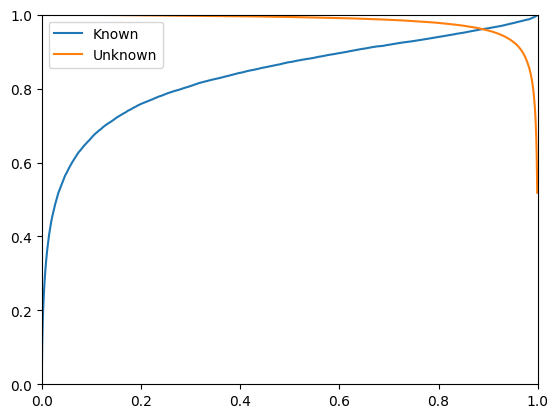

In [33]:
# 10-shot, 1 way, 30 query, 10 random unknown
import matplotlib.pyplot as plt

plt.plot(np.arange(0,1,0.001), known_acc)
plt.plot(np.arange(0,1,0.001), un_known_acc)

plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(["Known", "Unknown"])

known_acc[915], un_known_acc[915]

(0.872, 0.9568999409675598, 0.9656464457511902, 0.9240270269348478)

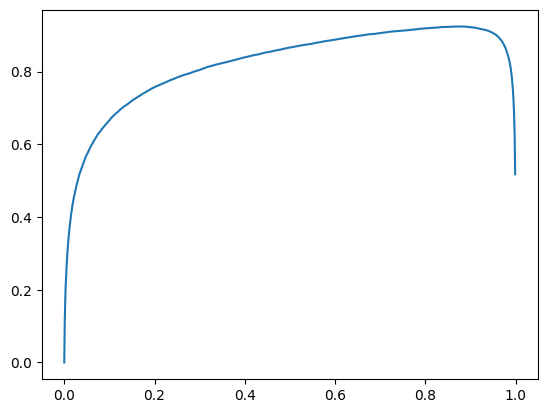

In [34]:
mul_prob = np.array(known_acc) * np.array(un_known_acc)

plt.plot(np.arange(0,1,0.001), mul_prob)
MAX, IDX = np.max(mul_prob), np.argmax(mul_prob)
IDX / 1000, known_acc[IDX], un_known_acc[IDX], mul_prob[IDX]